# How to run batch workloads
**Running batch workloads with the `iterate` function**

Fire Opal's `iterate` function is optimized for [submitting multiple jobs](https://docs.q-ctrl.com/fire-opal/topics/submitting-multiple-jobs), which either usually take the form of variational or batch workflows. Batching is required for workloads that have too many circuits to fit in a single job. When using the `iterate` function to submit jobs, they are automatically optimized to reduce queueing and pre-processing time by managing provider-specific features, like [Qiskit Runtime sessions](https://docs.quantum.ibm.com/run/sessions), behind the scenes.

Fire Opal supports a maximum of 300 circuits or parameter dictionaries per job.

## Summary workflow
The following steps describe the general workflow for running batch workloads.

### 1. Prepare the circuits
Prepare a batch of circuits and associated parameters, if using [parameterized quantum circuits (PQC)](https://docs.q-ctrl.com/fire-opal/user-guides/how-to-run-parameterized-quantum-circuits).

### 2. Split the input circuits or parameters
Split the array of circuits or the array of parameters into arrays of size no greater than the max job size.

### 3. Run the jobs using `iterate`
Run multiple jobs by calling the `iterate` function repeatedly for optimized pre-processing and execution.

## Example: Running a batch of parameterized circuits with `iterate`
In this example, we showcase the use of the `iterate` function to run a set of sample 3-qubit Quantum Approximate Optimization Algorithm circuits designed for the MaxCut problem. Instead of creating individual circuits, execution can be optimized by leveraging a PQC with multiple dictionaries defining the parameters to be bound at runtime. The array of parameter dictionaries must be split to accommodate the max size per job.

### 1. Import libraries and set up credentials

Note that for the circuit drawing function to run, you may need to install pylatexenc ```pip install pylatexenc```.

In [1]:
import fireopal as fo
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit import qasm3
import numpy as np

In this example, the iterative workload is run on IBM Quantum. The following code builds a credentials object using credentials that can be obtained on the [IBM Quantum Platform](http://quantum.ibm.com) dashboard.

In [ ]:
# These are the properties for the publicly available provider for IBM backends.
# If you have access to a private provider and wish to use it, replace these values.
hub = "ibm-q"
group = "open"
project = "main"
token = "YOUR_IBM_TOKEN"
credentials = fo.credentials.make_credentials_for_ibmq(
    token=token, hub=hub, group=group, project=project
)

### 2. Prepare the MaxCut circuits
This example uses parameterized quantum circuits (PQCs), which are supported in both Fire Opal's `execute` and `iterate` functions. PQCs must be converted to OpenQASM 3.0 for submission to Fire Opal.

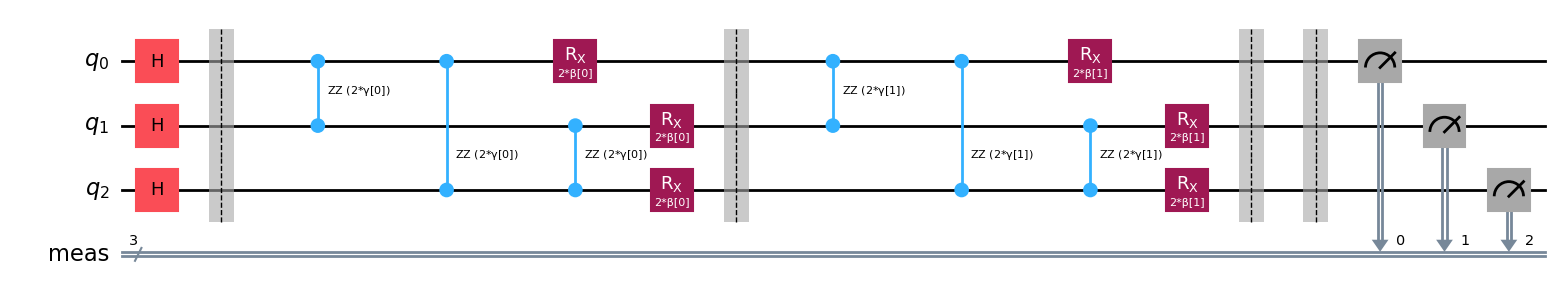

In [2]:
# Initialize a graph for the max-cut problem with 3 nodes
num_nodes = 3  # Specifies the number of nodes in the graph
graph_edges = [(0, 1), (0, 2), (1, 2)]  # Defines the edges between nodes
repetitions = 2  # Number of QAOA layers or 'p' value


def cost_layer(parameter, circuit):
    # Applies a ZZ gate with a parameterized angle to each edge in the graph, forming the cost layer
    for edge in graph_edges:
        circuit.rzz(2 * parameter, *edge)


def mixer_layer(parameter, circuit):
    # Applies an RX gate with a parameterized angle to each qubit, forming the mixer layer
    for i in range(num_nodes):
        circuit.rx(2 * parameter, i)


# Create a 3-qubit QAOA circuit with parametric layers
gammas = ParameterVector("γ", repetitions)
betas = ParameterVector("β", repetitions)

qc = QuantumCircuit(num_nodes)

# Prepare the initial state with Hadamard gates
for i in range(num_nodes):
    qc.h(i)
qc.barrier()

# Add QAOA layers: alternating cost and mixer layers
for p in range(repetitions):
    cost_layer(gammas[p], qc)
    mixer_layer(betas[p], qc)
    qc.barrier()

qc.measure_all()
qc.draw("mpl", fold=-1)

### 3. Set initial parameters or use randomly generated values
In this example, 400 sets of random parameters are generated and combined into an array of dictionaries. The resulting array must be split into two arrays to consider the maximum allowed array size per job.

In [3]:
# Generate sets of random values for the parameters
random_values = np.random.rand(400, 4)
parameter_dicts = [
    {param.name: val for param, val in zip(qc.parameters, values)}
    for values in random_values
]

# Split the array into multiple arrays of max size of 300
max_size = 300
result_arrays = np.array_split(
    parameter_dicts, np.ceil(len(parameter_dicts) / max_size)
)

### 4. Run the circuit with each array of parameters using `iterate`
Running the jobs using the `iterate` function optimizes the queueing and preprocessing time for batch executions.

In [ ]:
# Set shot count and define backend
# To get a list of supported backends, run fo.show_supported_devices(credentials)
shot_count = 2048
backend_name = "desired_backend"

# Collect results in array
jobs = []
circuits = [qasm3.dumps(qc)]

# Send circuits consecutively as a batch
for param_array in result_arrays:
    jobs.append(
        # Run each set of circuits via an iterate job
        fo.iterate(
            circuits=circuits,
            shot_count=shot_count,
            credentials=credentials,
            backend_name=backend_name,
            parameters=param_array.tolist(),
        )
    )

In [ ]:
# Poll for results
results = []
for job in jobs:
    results.append(job.result()["results"])

In [ ]:
# Stop iterating after all circuits are sent
fo.stop_iterate(credentials, backend_name)